In [ ]:
# Run validation if needed
! python validate.py --config_path 'configs/lr_config.yaml' --model 'GCN' --model_path 'saved_models/gcn/GCN_for_lrp01_2025-05-04_18-43-34.pt' --output_dir 'saved_metrics/gcn'

Unexpected error:
Traceback (most recent call last):
  File "c:\Users\Carlo\Documents\School\Masters\NUS\gnn_flood_modeling\validate.py", line 55, in main
    event_key = parse_model_path(args.model_path, args.model)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Carlo\Documents\School\Masters\NUS\gnn_flood_modeling\validate.py", line 33, in parse_model_path
    raise ValueError(f'Model path {model_path} does not exist.')
ValueError: Model path 'saved_models/gcn/GCN_for_lrp01_2025-05-04_09-05-49.pt' does not exist.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
saved_metrics_path = 'saved_metrics/gcn/GCN_lrp01_metrics.npz'
saved_metrics = np.load(saved_metrics_path, allow_pickle=True)
rmse = saved_metrics['rmse']
mae = saved_metrics['mae']
nse = saved_metrics['nse']
csi = saved_metrics['csi']

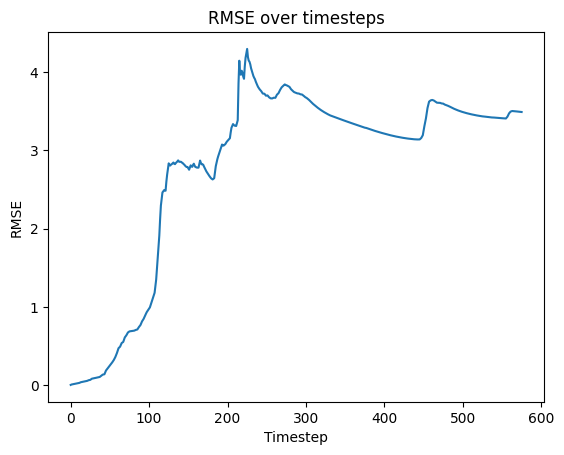

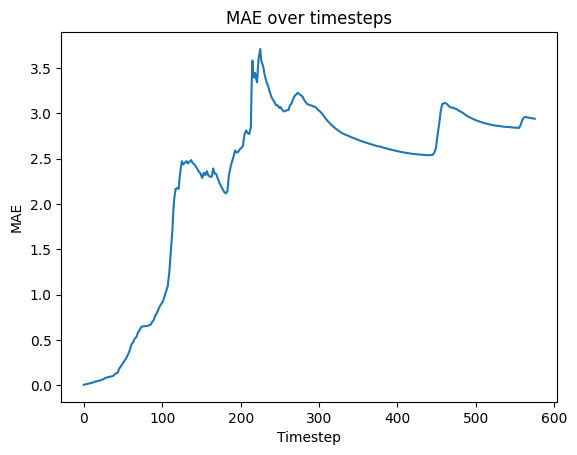

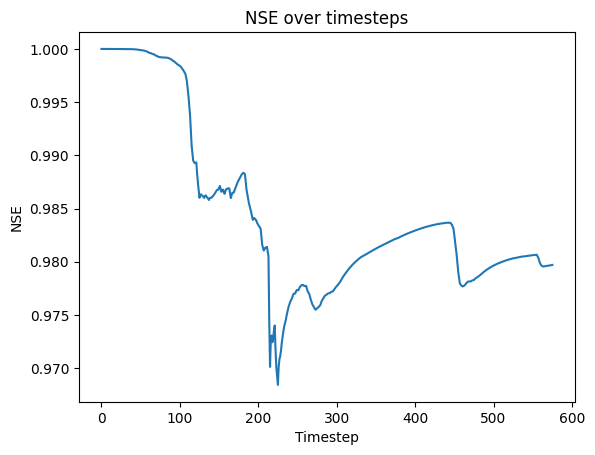

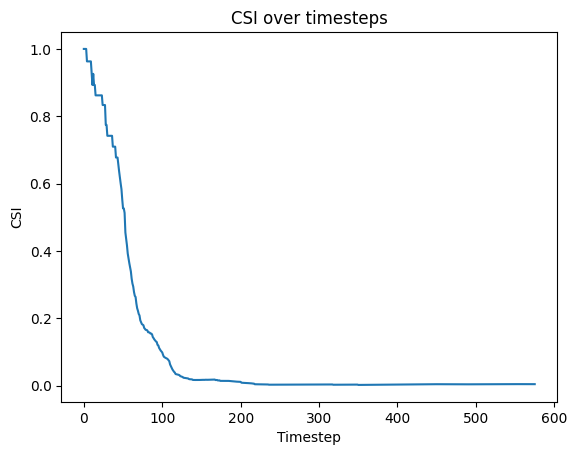

In [3]:
def plot(x, xlabel, ylabel, title):
    plt.plot(x)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot(rmse, xlabel='Timestep', ylabel='RMSE', title='RMSE over timesteps')
plot(mae, xlabel='Timestep', ylabel='MAE', title='MAE over timesteps')
plot(nse, xlabel='Timestep', ylabel='NSE', title='NSE over timesteps')
plot(csi, xlabel='Timestep', ylabel='CSI', title='CSI over timesteps')

In [4]:
rmse_flooded = saved_metrics['rmse_flooded']
mae_flooded = saved_metrics['mae_flooded']
nse_flooded = saved_metrics['nse_flooded']

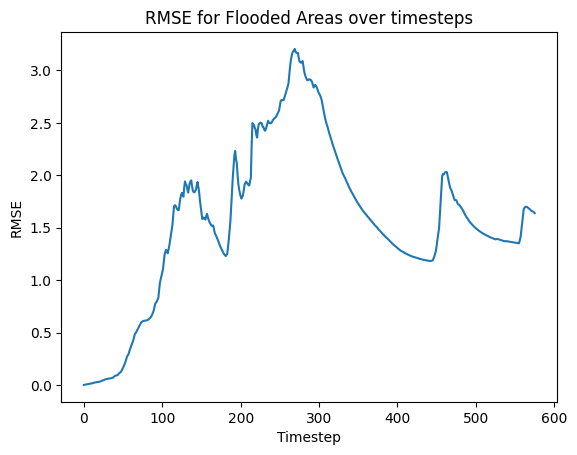

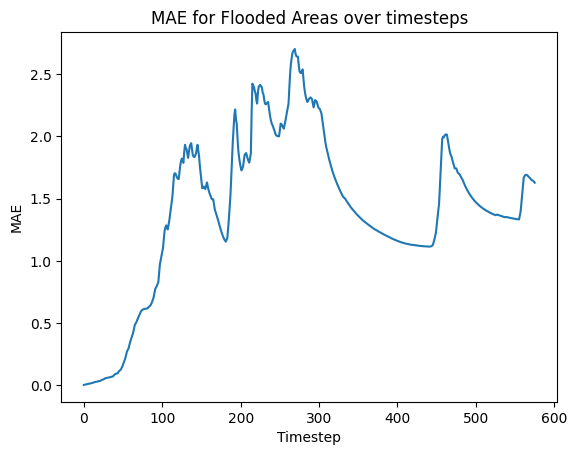

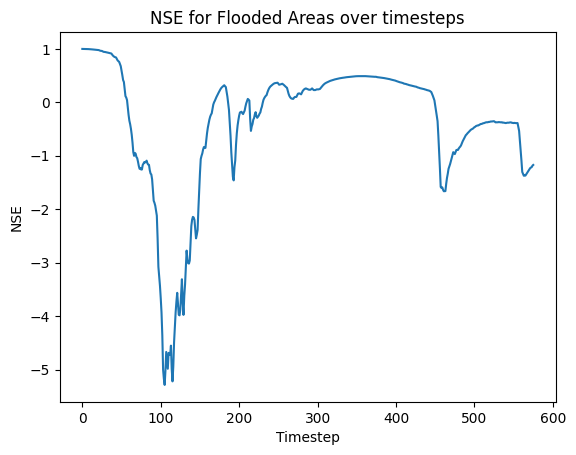

In [5]:
plot(rmse_flooded, xlabel='Timestep', ylabel='RMSE', title='RMSE for Flooded Areas over timesteps')
plot(mae_flooded, xlabel='Timestep', ylabel='MAE', title='MAE for Flooded Areas over timesteps')
plot(nse_flooded, xlabel='Timestep', ylabel='NSE', title='NSE for Flooded Areas over timesteps')

In [6]:
pred = saved_metrics['pred']
target = saved_metrics['target']

In [7]:
print(pred.shape)
print(target.shape)

(576, 22551, 1)
(576, 22551, 1)
